PyGSLIB
========

Cova3 test
---------------

This is a simple example on how to use raw cova3 to fit variograms




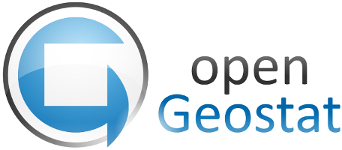

In [1]:
#general imports
import matplotlib.pyplot as plt   
import pygslib                 
import numpy as np 


#make the plots inline
%matplotlib inline  

Getting the data ready for work
---------
If the data is in GSLIB format you can use the function `pygslib.gslib.read_gslib_file(filename)` to import the data into a Pandas DataFrame. 


In [2]:
#get the data in gslib format into a pandas Dataframe
mydata= pygslib.gslib.read_gslib_file('../datasets/cluster.dat')  

In [3]:
# This is a 2D file, in this GSLIB version we require 3D data and drillhole name or domain code
# so, we are adding constant elevation = 0 and a dummy BHID = 1 
mydata['Zlocation']=0
mydata['bhid']=1

# printing to verify results
#print (' \n **** 5 first rows in my datafile \n\n  ', mydata.head(n=5))

## get some experimental variograms

In [4]:
# these are the parameters we need. Note that at difference of GSLIB this dictionary also stores 
# the actual data (ex, X, Y, etc.). 

#important! python is case sensitive 'bhid' is not equal to 'BHID'

parameters_exp = { 
'x'      :  mydata['Xlocation']   , # X coordinates, array('f') with bounds (nd), nd is number of data points
'y'      :  mydata['Ylocation'],    # Y coordinates, array('f') with bounds (nd)
'z'      :  mydata['Zlocation'],    # Z coordinates, array('f') with bounds (nd)
'bhid'   :  mydata['bhid'],         # bhid for downhole variogram, array('i') with bounds (nd)    
'vr'     :  mydata['Primary'],      # Variables, array('f') with bounds (nd,nv), nv is number of variables
'tmin'   : -1.0e21,                 # trimming limits, float
'tmax'   :  1.0e21,                 # trimming limits, float
'nlag'   :  10,                     # number of lags, int
'xlag'   :  4,                      # lag separation distance, float                
'xltol'  :  2,                      # lag tolerance, float
'azm'    : [90],                # azimuth, array('f') with bounds (ndir)
'atol'   : [22.5],          # azimuth tolerance, array('f') with bounds (ndir)
'bandwh' : [10000],              # bandwith h, array('f') with bounds (ndir)
'dip'    : [0],                 # dip, array('f') with bounds (ndir)
'dtol'   : [10],              # dip tolerance, array('f') with bounds (ndir)
'bandwd' : [10],              # bandwith d, array('f') with bounds (ndir)
'isill'  : 0,                       # standardize sills? (0=no, 1=yes), int
'sills'  : [100],                   # variance used to std the sills, array('f') with bounds (nv)
'ivtail' : [1],                     # tail var., array('i') with bounds (nvarg), nvarg is number of variograms
'ivhead' : [1],                     # head var., array('i') with bounds (nvarg)
'ivtype' : [7],                     # variogram type, array('i') with bounds (nvarg)
'maxclp' : 50000}                   # maximum number of variogram point cloud to use, input int

'''
Remember this is GSLIB... use this code to define variograms
type 1 = traditional semivariogram
     2 = traditional cross semivariogram
     3 = covariance
     4 = correlogram
     5 = general relative semivariogram
     6 = pairwise relative semivariogram
     7 = semivariogram of logarithms
     8 = semimadogram

'''              

#check the variogram is ok
assert pygslib.gslib.check_gamv_par(parameters_exp)==1 , 'sorry this parameter file is wrong' 


In [5]:
#Now we are ready to calculate the veriogram
pdis,pgam, phm,ptm,phv,ptv,pnump, cldi, cldj, cldg, cldh = pygslib.gslib.gamv(parameters_exp)


In [6]:
nvrg = pdis.shape[0]
ndir = pdis.shape[1]
nlag = pdis.shape[2]-2

Plotting results
-----------------------

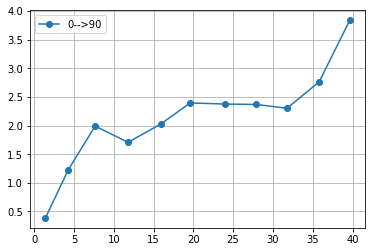

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

#plotting the variogram 1 only
v=0

# in all the directions calculated
for d in range(ndir):
    dip=parameters_exp['dip'][d]
    azm=parameters_exp['azm'][d]
    plt.plot (pdis[v, d, 1:], pgam[v, d, 1:], '-o', label=str(dip) + '-->' + str(azm))

# adding nice features to the plot
plt.legend()
plt.grid(True)
plt.show()


Fit the variogram
-----

We are using variogram of logarithms... 


In [8]:
#rotatios matrix (one per structure)
rmatrix_d1=pygslib.gslib.setrot(ang1=0,ang2=0,ang3=0,anis1=1,anis2=1,ind=1,maxrot=2)  #rotation structure 1
rmatrix_d2=pygslib.gslib.setrot(ang1=0,ang2=0,ang3=0,anis1=1,anis2=1,ind=2,maxrot=2)  #rotation structure 2

rmatrix=rmatrix_d1+rmatrix_d2

print (rmatrix)

[[[-4.37113883e-08  1.00000000e+00  0.00000000e+00]
  [-1.00000000e+00 -4.37113883e-08  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[-4.37113883e-08  1.00000000e+00  0.00000000e+00]
  [-1.00000000e+00 -4.37113883e-08  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]


In [9]:
parameters_mod = { 
                'x1'     :  0,            # X coordinates, point 1
                'y1'     :  0,            # Y coordinates, point 1
                'z1'     :  0,            # Z coordinates, point 1
                'x2'     :  1,            # X coordinates, point 2
                'y2'     :  0,            # Y coordinates, point 2
                'z2'     :  0,            # Z coordinates, point 2
                'nst'    :  2,            # number of nested structures, array('i') with bounds (ivarg), 
                                          # ivarg is variogram number
                'c0'     :  [0.01],        # nugget,  array('f') with bounds (ivarg)  
                'it'     :  [3, 3],        # structure type,  array('i') with bounds (ivarg)              
                'cc'     :  [1, 1.4],   # variance, array('f') with bounds (nvarg*nst[0])
                'aa'     :  [8., 22.],      # parameter a (or range), array('f') with bounds (nvarg*nst[0])
                'irot'   :  1,            # index of the rotation matrix for the first nested structure
                                          # the second nested structure will use irot+1, the third irot+2, and so on
                'rotmat' :  rmatrix}       # rotation matrices (output of the funtion setrot)

In [10]:
# this is the covariance between the points x1, x2
cmax,cova=pygslib.gslib.cova3(parameters_mod)
print (cmax, cova)

2.4099998474121094 2.2430224418640137


In [11]:
res=300
mh=np.linspace(0,40, res)
mc=np.zeros(res)
mv=np.zeros(res)

for i,h in enumerate(mh):
    parameters_mod['x2']=h
    cmax,cova=pygslib.gslib.cova3(parameters_mod)
    mc[i]=cova
    mv[i]=cmax- cova
    
    

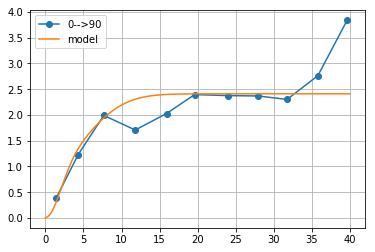

In [12]:
#plotting the variogram 1 only
v=0

# in all the directions calculated
for d in range(ndir):
    dip=parameters_exp['dip'][d]
    azm=parameters_exp['azm'][d]
    plt.plot (pdis[v, d, 1:], pgam[v, d, 1:], '-o', label=str(dip) + '-->' + str(azm))

# add model
plt.plot (mh, mv, '-', label = 'model')
    
# adding nice features to the plot
plt.legend()
plt.grid(True)
plt.show()